# EDA of the Expanded Groove MIDI Dataset

In [32]:
# uncomment this when running outside of Kaggle
# !mkdir -p "../input/the-expanded-groove-midi-dataset" && wget -nc https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip -O ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0-midi.zip && unzip -n ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0-midi.zip -d ../input/the-expanded-groove-midi-dataset/

--2023-12-13 20:00:46--  https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.187.187, 142.250.187.155, 142.250.184.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.187.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107076192 (102M) [application/zip]
Saving to: ‘../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0-midi.zip’

../input/the-expand 100%[===================>] 102.12M  7.78MB/s    in 12s     

2023-12-13 20:00:59 (8.20 MB/s) - ‘../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0-midi.zip’ saved [107076192/107076192]

Archive:  ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0-midi.zip
   creating: ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0/
  inflating: ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0/LICENSE  
   creating: ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0/drummer1/
   creating: ../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0/drummer1/eval_session/
  inflating: ../inp

In [16]:
import os

In [33]:
DATASET_BASE_PATH = os.path.join('..', 'input', 'the-expanded-groove-midi-dataset', 'e-gmd-v1.0.0')
DATASET_METADATA_PATH = os.path.join(DATASET_BASE_PATH, 'e-gmd-v1.0.0.csv')

## Imports

We are going to need [partitura](https://github.com/CPJKU/partitura) for MIDI playback in the notebook. I also recommend this lib for working with MIDI performances and/or scores.

In [4]:
!pip3 install music21 partitura scikit-learn torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.5 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 3.6 MB/s eta 0:00:000:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 4.2 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 3.1 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.8 MB/s eta 0:00:003.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.4 MB/s eta 0:00:000:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 2.7 MB/s eta 0:0

In [6]:
import pandas as pd
import partitura
import matplotlib.pyplot as plt
import numpy as np


## Helper funcs and classes

1. Partitura gives us an ndarray of tuples, containing note info. Making a helper class to make it easier to work with:

In [7]:
from enum import Enum

class Idx(Enum):
    ONSET_SECS = 0
    DURATION_SECS = 1
    ONSET_TICKS = 2
    DURATION_TICKS = 3
    PITCH = 4
    VELOCITY = 5
    TRACK = 6
    CHANNEL = 7
    ID = 8


class MidiNote:
    def __init__(self, notetuple):
        self.notetuple = notetuple

    @property
    def begin_secs(self):
        return self.notetuple[Idx.ONSET_SECS.value]

    @property
    def duration_secs(self):
        return self.notetuple[Idx.DURATION_SECS.value]

    @property
    def begin_ticks(self):
        return self.notetuple[Idx.ONSET_TICKS.value]

    @property
    def duration_ticks(self):
        return self.notetuple[Idx.DURATION_TICKS.value]

    @property
    def pitch(self):
        return self.notetuple[Idx.PITCH.value]

    @property
    def velocity(self):
        return self.notetuple[Idx.VELOCITY.value]

    @property
    def track(self):
        return self.notetuple[Idx.TRACK.value]

    @property
    def channel(self):
        return self.notetuple[Idx.CHANNEL.value]

    @property
    def id(self):
        return self.notetuple[Idx.ID.value]

    @property
    def end_secs(self):
        return self.begin_secs + self.duration_secs

    @property
    def end_ticks(self):
        return self.begin_ticks + self.duration_ticks

    def __repr__(self):
        return f'MidiNote({self.notetuple})'

2. Creating a piano-roll representation of a MIDI track

A piano-roll is a matrix where the rows are the notes and the columns are the time steps.

We can extend it to add the velocity of the note as its value. Color-coding can be used to display the velocity.

That way we would get a nice 3D overview of the performance that shows the velocity of each note at each time step.

In [8]:
DRUM_MIDI_NAME = {
    35: 'Acoustic Bass Drum',
    36: 'Bass Drum 1',
    37: 'Side Stick',
    38: 'Acoustic Snare',
    39: 'Hand Clap',
    40: 'Electric Snare',
    41: 'Low Floor Tom',
    42: 'Closed Hi Hat',
    43: 'High Floor Tom',
    44: 'Pedal Hi-Hat',
    45: 'Low Tom',
    46: 'Open Hi-Hat',
    47: 'Low-Mid Tom',
    48: 'Hi-Mid Tom',
    49: 'Crash Cymbal 1',
    50: 'High Tom',
    51: 'Ride Cymbal 1',
    52: 'Chinese Cymbal',
    53: 'Ride Bell',
    54: 'Tambourine',
    55: 'Splash Cymbal',
    56: 'Cowbell',
    57: 'Crash Cymbal 2',
    58: 'Vibra Slap',
    59: 'Ride Cymbal 2',
    60: 'High Bongo',
    61: 'Low Bongo',
    62: 'Mute High Conga',
    63: 'Open High Conga',
    64: 'Low Conga',
    65: 'High Timbale',
    66: 'Low Timbale',
    67: 'High Agogo',
    68: 'Low Agogo',
    69: 'Cabasa',
    70: 'Maracas',
    71: 'Short Whistle',
    72: 'Long Whistle',
    73: 'Short Guiro',
    74: 'Long Guiro',
    75: 'Claves',
    76: 'High Wood Block',
    77: 'Low Wood Block',
    78: 'Mute Cuica',
    79: 'Open Cuica',
    80: 'Mute Triangle',
    81: 'Open Triangle'
}

In [54]:
def drums_roll(notes):
    # get the time range of the piece
    # note: we will be working with ticks instead of seconds beacause they are integers
    start_tick = min(MidiNote(n).begin_ticks for n in notes)
    end_tick = max(MidiNote(n).end_ticks for n in notes)

    max_pitch = max(MidiNote(n).pitch for n in notes)
    min_pitch = min(MidiNote(n).pitch for n in notes)

    pitches = max_pitch - min_pitch + 1
    ticks = int(end_tick - start_tick)

    # init the piano-roll matrix with zeroes
    roll = np.zeros((pitches, ticks))

    # fill the matrix with the notes
    for n in notes:
        mn = MidiNote(n)
        pitch_idx = mn.pitch - min_pitch
        start_idx = int(mn.begin_ticks - start_tick)
        end_idx = int(mn.end_ticks - start_tick)
        velocity_normalized = mn.velocity / 127
        roll[pitch_idx, start_idx:end_idx] = velocity_normalized

    # plot the piano-roll
    plt.figure(figsize=(15, 12))
    plt.imshow(roll, aspect='auto', origin='lower', interpolation='none', cmap='Reds')
    plt.xlabel('time (MIDI ticks)')
    plt.ylabel('drum kit piece or MIDI pitch')
    plt.yticks(
        range(roll.shape[0]),
        [
            DRUM_MIDI_NAME.get(min_pitch + i, min_pitch + i)
            for i in range(roll.shape[0])
        ]
    )

    cbar = plt.colorbar(ticks=np.linspace(0, 1, 128))
    cbar.set_label('Velocity')
    ticks_count = 16
    cbar.set_ticks(np.linspace(0, 1, ticks_count))
    cbar.set_ticklabels(np.linspace(0, 127, ticks_count, dtype=int))
    

    plt.show()

3. MIDI playback in the notebook


In [11]:
!brew install fluidsynth || apt-get install fluidsynth

==> Downloading https://formulae.brew.sh/api/formula.jws.json

==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/fluid-synth/manifests/2.3.4
######################################################################### 100.0%
==> Fetching dependencies for fluid-synth: libogg, flac, lame, libvorbis, mpg123, opus, libsndfile and portaudio
==> Downloading https://ghcr.io/v2/homebrew/core/libogg/manifests/1.3.5-2
######################################################################### 100.0%
==> Fetching libogg
==> Downloading https://ghcr.io/v2/homebrew/core/libogg/blobs/sha256:d8591422a6a
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/flac/manifests/1.4.3
######################################################################### 100.0%
==> Fetching flac
==> Downloading http

In [12]:
!pip3 install pyfluidsynth

A soundfont needs to be downloaded (that has drums). I will use a General MIDI one: FluidR3_GM.sf2.

In [13]:
!wget -nc -P sf/big/ https://keymusician01.s3.amazonaws.com/FluidR3_GM.zip && unzip -n sf/big/FluidR3_GM.zip -d sf/big/FluidR3_GM

--2023-12-13 19:40:19--  https://keymusician01.s3.amazonaws.com/FluidR3_GM.zip
Resolving keymusician01.s3.amazonaws.com (keymusician01.s3.amazonaws.com)... 3.5.29.238, 54.231.204.17, 3.5.28.135, ...
Connecting to keymusician01.s3.amazonaws.com (keymusician01.s3.amazonaws.com)|3.5.29.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129768411 (124M) [application/zip]
Saving to: ‘sf/big/FluidR3_GM.zip’

FluidR3_GM.zip      100%[===================>] 123.76M   395KB/s    in 4m 50s  

2023-12-13 19:45:09 (438 KB/s) - ‘sf/big/FluidR3_GM.zip’ saved [129768411/129768411]

Archive:  sf/big/FluidR3_GM.zip
  inflating: sf/big/FluidR3_GM/FluidR3_GM.sf2  
  inflating: sf/big/FluidR3_GM/README.txt  
  inflating: sf/big/FluidR3_GM/copyright.txt  


In [14]:
SF_PATH = os.path.join('sf', 'big', 'FluidR3_GM', 'FluidR3_GM.sf2')

In [15]:
import fluidsynth
from IPython.display import Audio

def play_midi_file(path, sr=44100):
    """Play the first track of a MIDI file in the Jupyter notebook."""
    m = partitura.load_performance_midi(path)
    notes = m.performedparts[0].note_array()
    return play_midi_notes(notes, sr=sr)


def play_midi_notes(notes: np.ndarray, sr=44100):
    # Set up MIDI player
    fl = fluidsynth.Synth(samplerate=sr)
    sfid = fl.sfload(SF_PATH)

    # !!! Setup channel, bank and preset according to the specific souondfont you are using
    channel = 9
    bank = 128
    preset = 0

    fl.program_select(channel, sfid, bank, preset)

    # Get a timeline of all note on and note off events
    # and sort it so that it can be iterated in order
    events: dict[float, tuple[str, MidiNote]] = {}
    events.update({MidiNote(n).begin_secs : ("on", MidiNote(n)) for n in notes})
    events.update({MidiNote(n).end_secs : ("off", MidiNote(n)) for n in notes})
    sorted_events_keys = sorted(events.keys())

    # Render the MIDI note events as audio
    audio_data = []
    for curr_time, next_time in zip(sorted_events_keys[:-1], sorted_events_keys[1:]):
        event_type = events[curr_time][0]
        note = events[curr_time][1]

        if event_type == "on":
            fl.noteon(note.channel, note.pitch, note.velocity)
        elif event_type == "off":
            fl.noteoff(note.channel, note.pitch)

        time_interval = next_time - curr_time
        interval_samples = fl.get_samples(int(time_interval * sr))
        
        audio_data.extend(interval_samples[::2]) # cut off one of the stereo channels
        # because I could not find how to set the Synth to play mono

    # Normalize audio data and play it in the notebook
    audio_data = np.array(audio_data, dtype="int16")
    audio_data = audio_data / (2**15 - 1)
    return Audio(audio_data, rate=sr)

## What's inside?

In [34]:
df = pd.read_csv(DATASET_METADATA_PATH)

In [35]:
df.sample(10)

drummer            session                     id            style  \
8728   drummer1  drummer1/session1  drummer1/session1/186           reggae   
30735  drummer7  drummer7/session2    drummer7/session2/3             rock   
25662  drummer4  drummer4/session1    drummer4/session1/8    blues/shuffle   
29845  drummer7  drummer7/session2  drummer7/session2/125           hiphop   
19296  drummer1  drummer1/session2   drummer1/session2/55             punk   
31219  drummer7  drummer7/session2   drummer7/session2/43             rock   
27024  drummer5  drummer5/session2    drummer5/session2/3  latin/brazilian   
21336  drummer1  drummer1/session3    drummer1/session3/6      dance/disco   
16210  drummer1  drummer1/session2   drummer1/session2/15          country   
43889  drummer7  drummer7/session1    drummer7/session1/2             rock   

       bpm beat_type time_signature    duration       split  \
8728    78      fill            4-4    3.076916       train   
30735  120      beat            4-4    4.000000       train   
25662  112      beat            4-4    8.571429       train   
29845  140      fill            4-4    5.181202       train   
19296  128      fill            4-4    1.733243       train   
31219  112      fill            4-4    3.394331       train   
27024  101      beat            4-4  102.575488       train   
21336  120      beat            4-4  225.995533       train   
16210  114      fill            4-4    1.892426       train   
43889   86      fill            4-4    5.799184  validation   

                                           midi_filename  \
8728     drummer1/session1/186_reggae_78_fill_4-4_8.midi   
30735      drummer7/session2/3_rock_120_beat_4-4_51.midi   
25662  drummer4/session1/8_blues-shuffle_112_beat_4-4...   
29845  drummer7/session2/125_hiphop_140_fill_4-4_12.midi   
19296      drummer1/session2/55_punk_128_fill_4-4_5.midi   
31219     drummer7/session2/43_rock_112_fill_4-4_10.midi   
27024  drummer5/session2/3_latin-brazilian_101_beat_4...   
21336  drummer1/session3/6_dance-disco_120_beat_4-4_1...   
16210   drummer1/session2/15_country_114_fill_4-4_8.midi   
43889       drummer7/session1/2_rock_86_fill_4-4_42.midi   

                                          audio_filename  \
8728      drummer1/session1/186_reggae_78_fill_4-4_8.wav   
30735       drummer7/session2/3_rock_120_beat_4-4_51.wav   
25662  drummer4/session1/8_blues-shuffle_112_beat_4-4...   
29845   drummer7/session2/125_hiphop_140_fill_4-4_12.wav   
19296       drummer1/session2/55_punk_128_fill_4-4_5.wav   
31219      drummer7/session2/43_rock_112_fill_4-4_10.wav   
27024  drummer5/session2/3_latin-brazilian_101_beat_4...   
21336  drummer1/session3/6_dance-disco_120_beat_4-4_1...   
16210    drummer1/session2/15_country_114_fill_4-4_8.wav   
43889        drummer7/session1/2_rock_86_fill_4-4_42.wav   

                        kit_name  
8728                   Deep Daft  
30735                 808 Simple  
25662                 909 Simple  
29845               Classic Rock  
19296                 Tight Prog  
31219  JingleStacks (2nd Hi-Hat)  
27024    More Cowbell (Pop-Rock)  
21336                Dark Hybrid  
16210                  Deep Daft  
43889           Bigga Bop (Jazz)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45537 entries, 0 to 45536
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   drummer         45537 non-null  object 
 1   session         45537 non-null  object 
 2   id              45537 non-null  object 
 3   style           45537 non-null  object 
 4   bpm             45537 non-null  int64  
 5   beat_type       45537 non-null  object 
 6   time_signature  45537 non-null  object 
 7   duration        45537 non-null  float64
 8   split           45537 non-null  object 
 9   midi_filename   45537 non-null  object 
 10  audio_filename  45537 non-null  object 
 11  kit_name        45537 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 4.2+ MB


In [56]:
df.describe()

bpm      duration
count  45537.000000  45537.000000
mean     109.805477     35.140608
std       23.992195     66.746390
min       50.000000      0.669841
25%       95.000000      2.068957
50%      110.000000      3.502789
75%      125.000000     36.179592
max      290.000000    611.754989

array([[<Axes: title={'center': 'bpm'}>,
        <Axes: title={'center': 'duration'}>]], dtype=object)

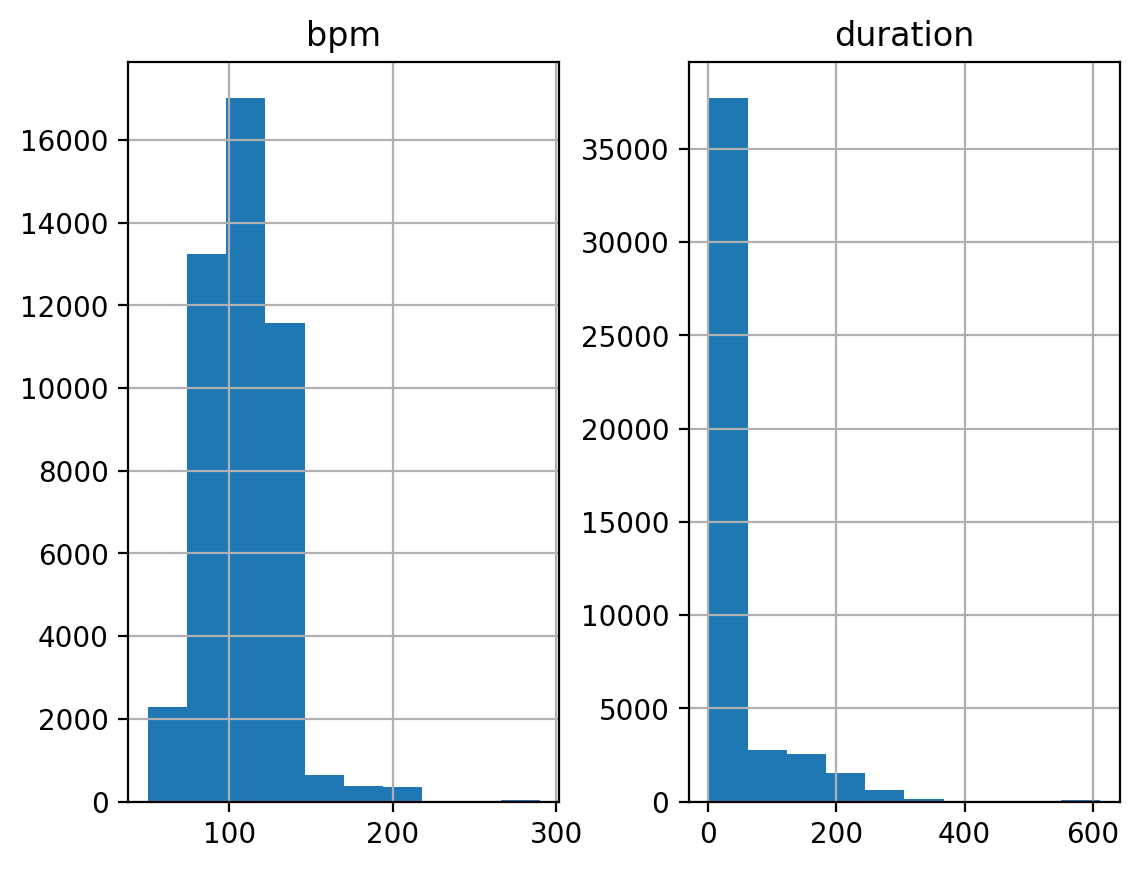

In [58]:
df.hist()

In [60]:
df["style"].value_counts()

style
rock                     10621
hiphop                    3655
funk                      2838
punk                      2494
jazz                      1935
                         ...  
rock/rockabilly             43
rock/folk                   43
latin/reggaeton             43
jazz/fast                   43
latin/brazilian-frevo       43
Name: count, Length: 74, dtype: int64

In [61]:
df["time_signature"].value_counts()

time_signature
4-4    45021
3-4      215
6-8      215
5-4       43
5-8       43
Name: count, dtype: int64

In [62]:
df["beat_type"].value_counts()

beat_type
fill    26961
beat    18576
Name: count, dtype: int64

In [63]:
df["split"].value_counts()

split
train         35217
test           5289
validation     5031
Name: count, dtype: int64

array([[<Axes: title={'center': 'bpm'}>,
        <Axes: title={'center': 'duration'}>]], dtype=object)

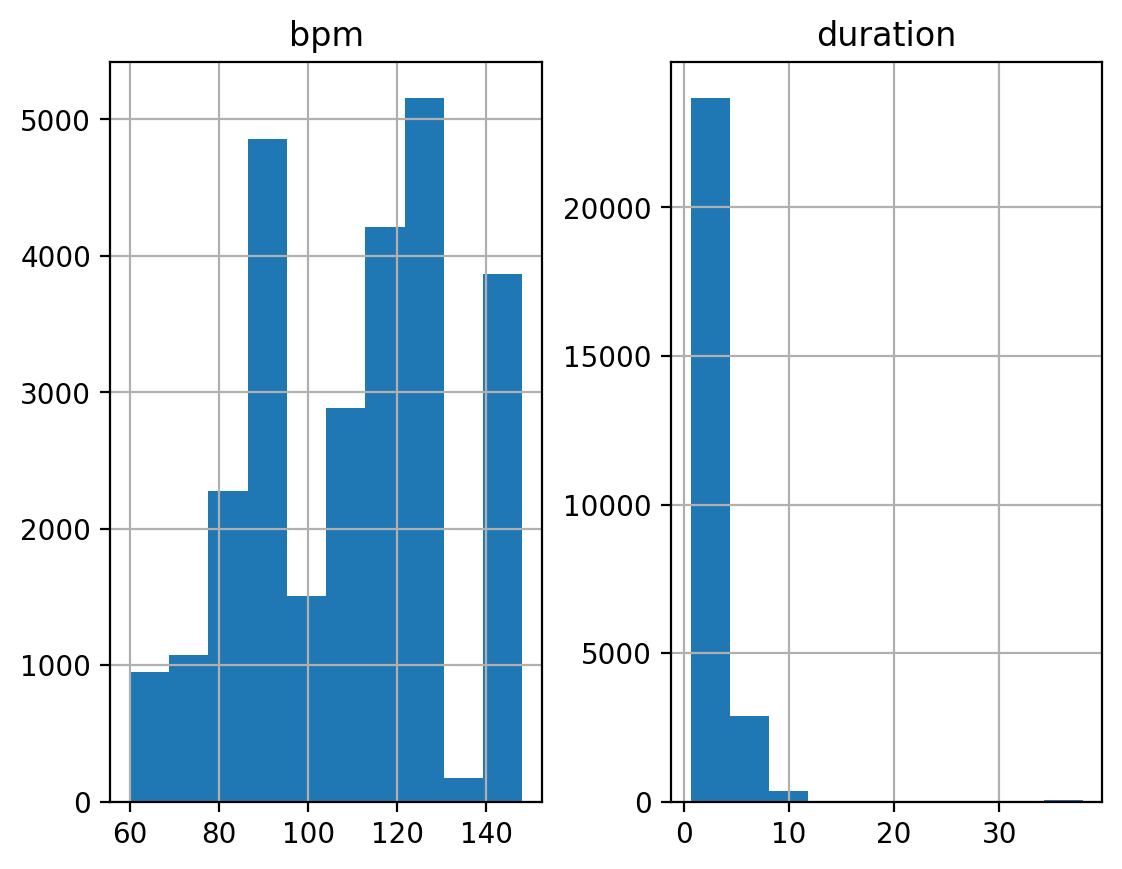

In [65]:
# Only fills
df[df["beat_type"] == "fill"].hist()

array([[<Axes: title={'center': 'bpm'}>,
        <Axes: title={'center': 'duration'}>]], dtype=object)

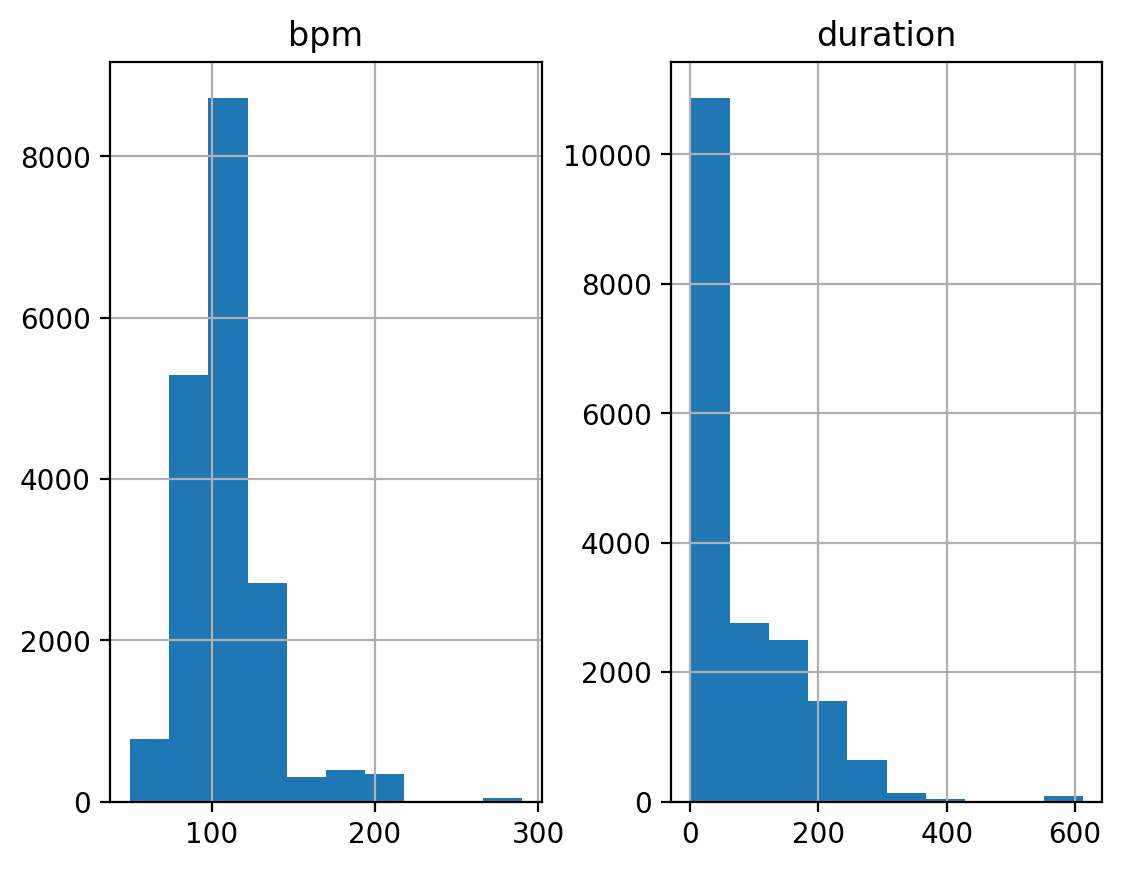

In [66]:
# Only beats
df[df["beat_type"] == "beat"].hist()

### Explore a file

In [37]:
example_midi_filepath = os.path.join(DATASET_BASE_PATH, df.iloc[0]['midi_filename'])
example_midi_filepath

'../input/the-expanded-groove-midi-dataset/e-gmd-v1.0.0/drummer1/eval_session/1_funk-groove1_138_beat_4-4_1.midi'

In [38]:
example_midi = partitura.load_performance_midi(example_midi_filepath)
example_midi.performedparts

In [39]:
example_notes = example_midi.performedparts[0].note_array()
example_notes[:10]

array([(0.00271739, 0.10144937,   3, 112, 55, 60, 0, 9, 'n0'),
       (0.00634059, 0.10054357,   7, 111, 51, 55, 0, 9, 'n1'),
       (0.00905798, 0.09963777,  10, 110, 36, 64, 0, 9, 'n2'),
       (0.19112337, 0.10054357, 211, 111, 36, 57, 0, 9, 'n3'),
       (0.2155799 , 0.09963777, 238, 110, 51, 31, 0, 9, 'n4'),
       (0.40398586, 0.10144937, 446, 112, 44, 77, 0, 9, 'n5'),
       (0.42300764, 0.10054357, 467, 111, 51, 54, 0, 9, 'n6'),
       (0.430254  , 0.10054357, 475, 111, 38, 93, 0, 9, 'n7'),
       (0.6032614 , 0.10235517, 666, 113, 44, 52, 0, 9, 'n8'),
       (0.6376817 , 0.10144937, 704, 112, 51, 42, 0, 9, 'n9')],
      dtype=[('onset_sec', '<f4'), ('duration_sec', '<f4'), ('onset_tick', '<i4'), ('duration_tick', '<i4'), ('pitch', '<i4'), ('velocity', '<i4'), ('track', '<i4'), ('channel', '<i4'), ('id', '<U256')])

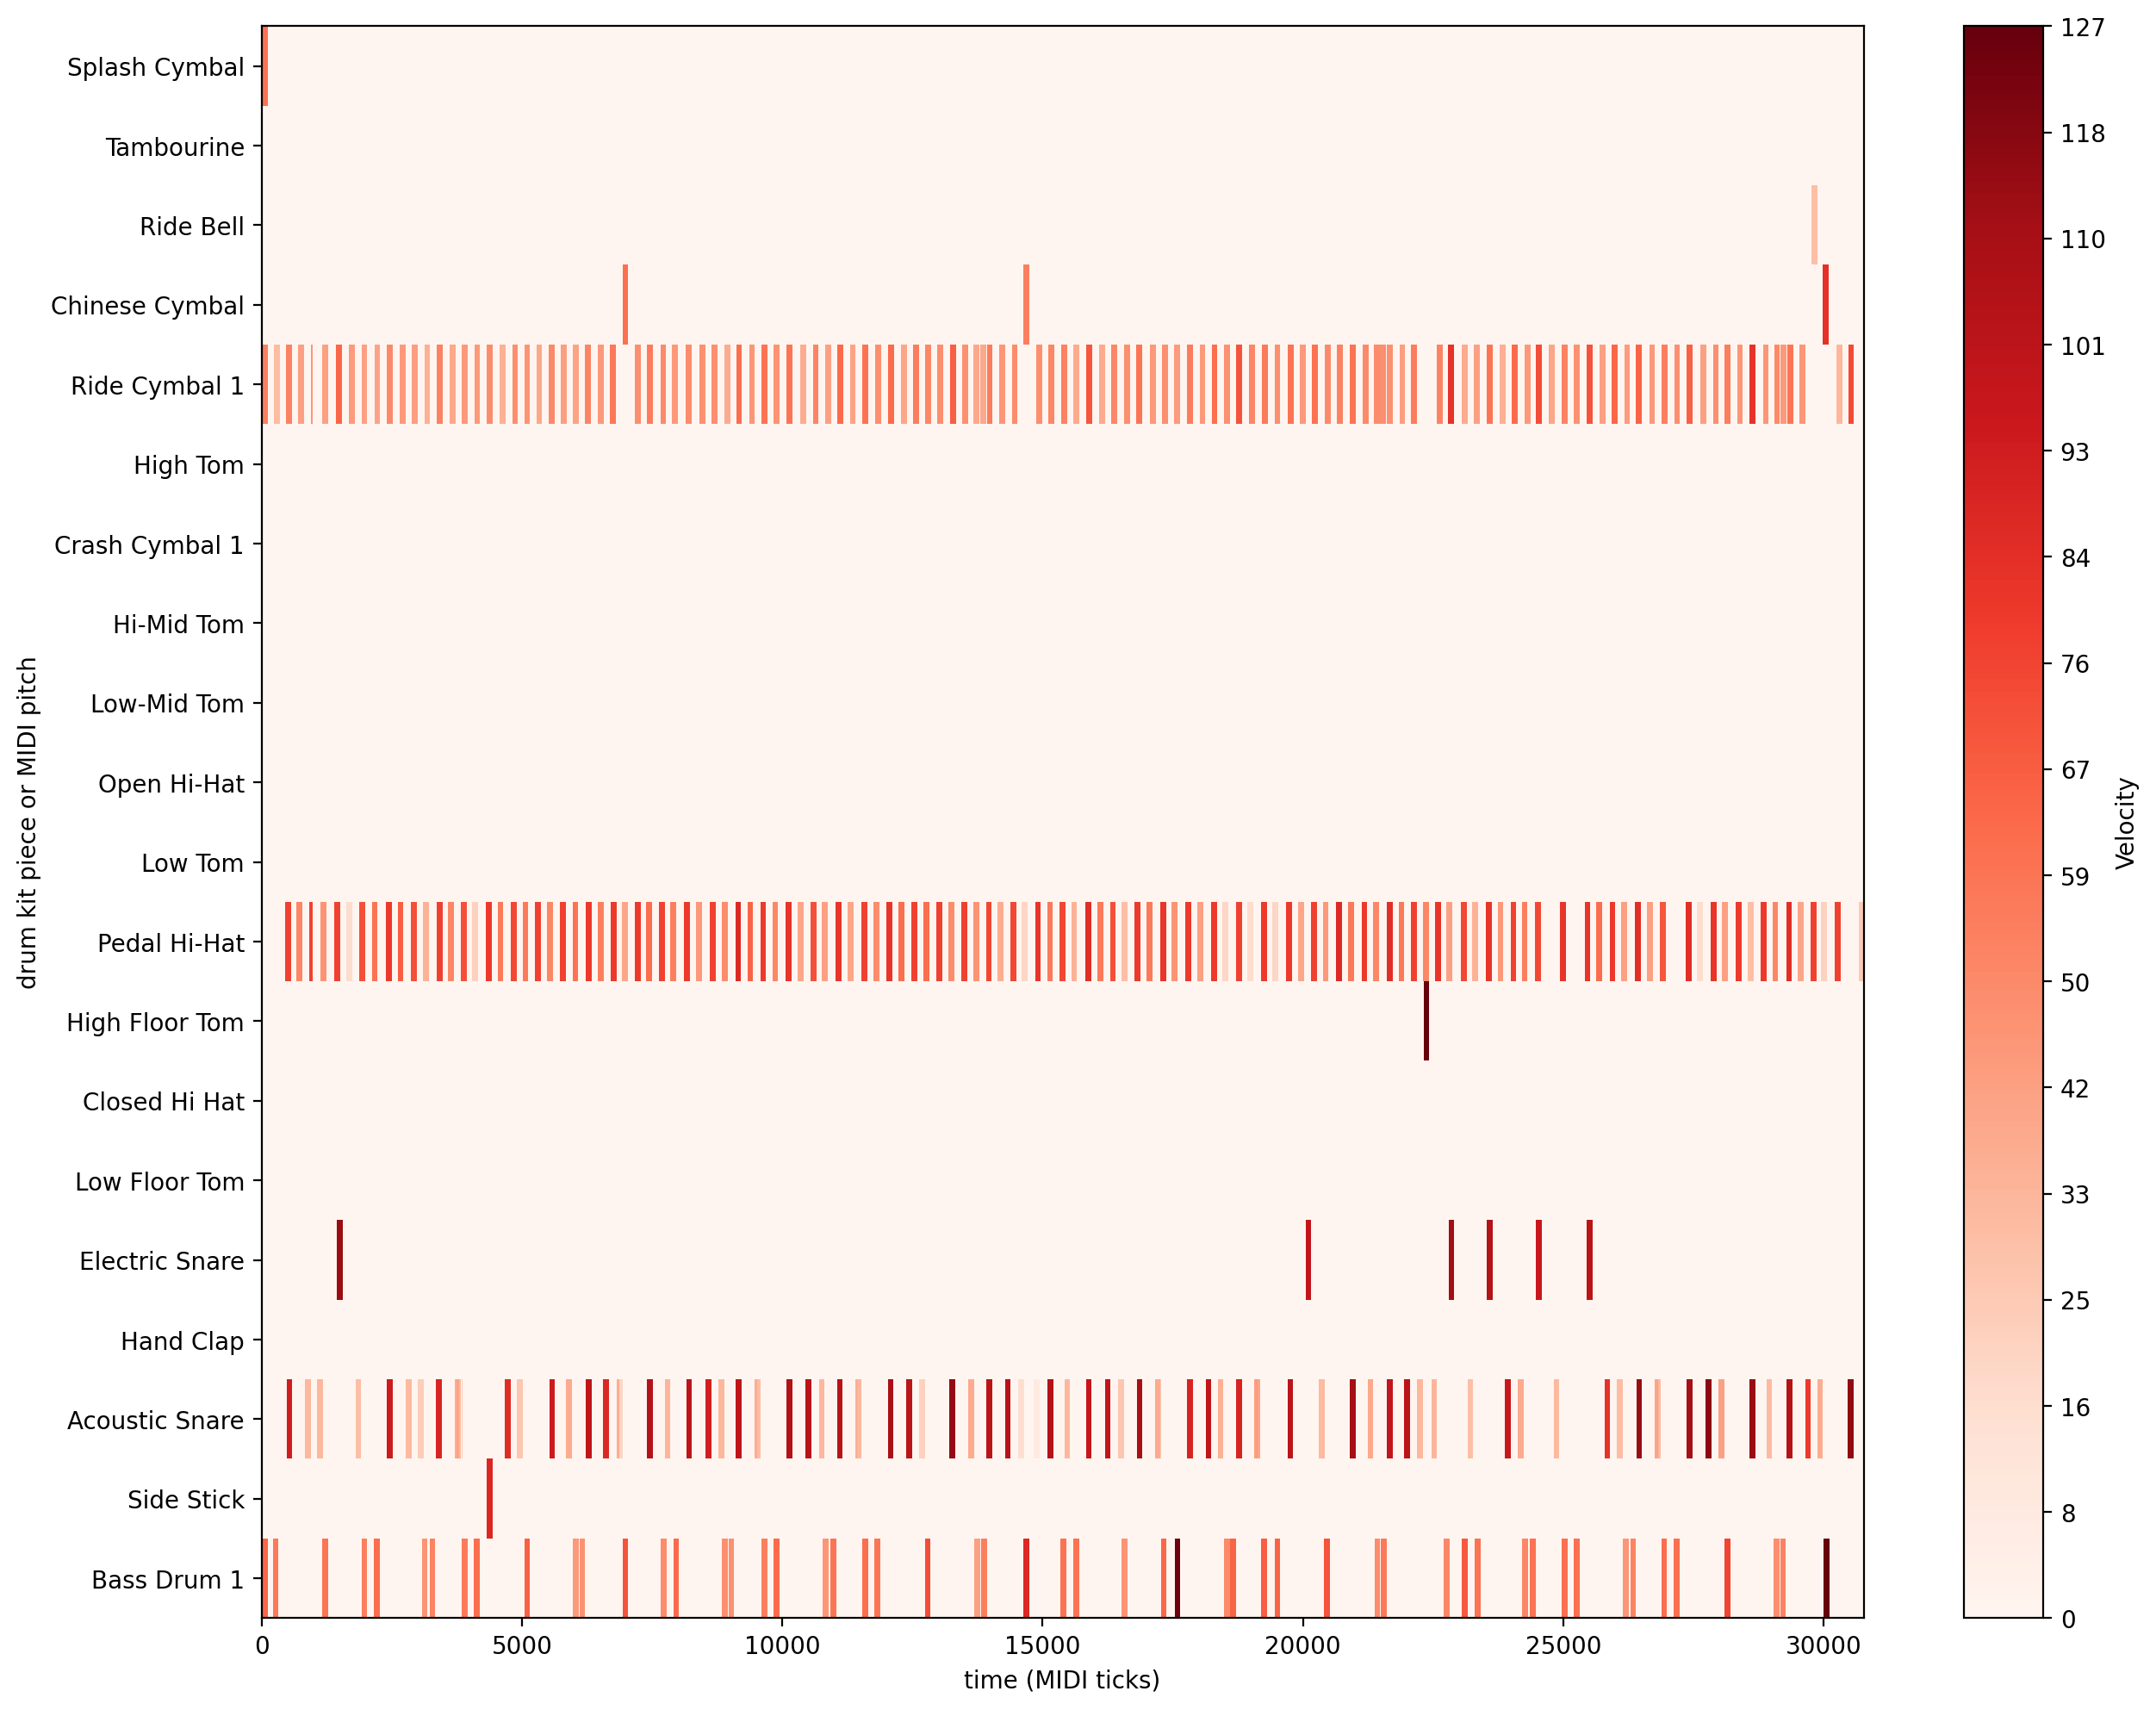

In [55]:
drums_roll(example_notes)

In [41]:
play_midi_notes(example_notes)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
